Text(0.5, 1.0, 'Original image')

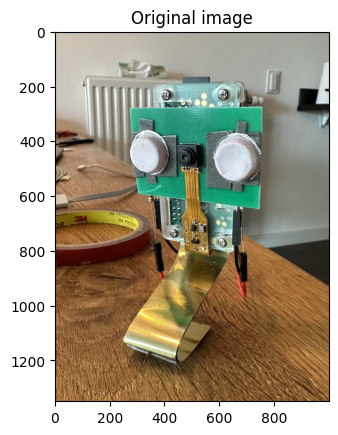

In [240]:
from matplotlib import pyplot as plt
import numpy as np
import pytesseract
import cv2

class ReaderError(Exception):
    """Meter reader generic exception"""

img_path = "./img/rpi-1.jpg"

# Load the input image and convert to RGB for correct display
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig = image.copy()

plt.imshow(orig)
plt.title("Original image")

84 157


Text(0.5, 1.0, 'Dilated image')

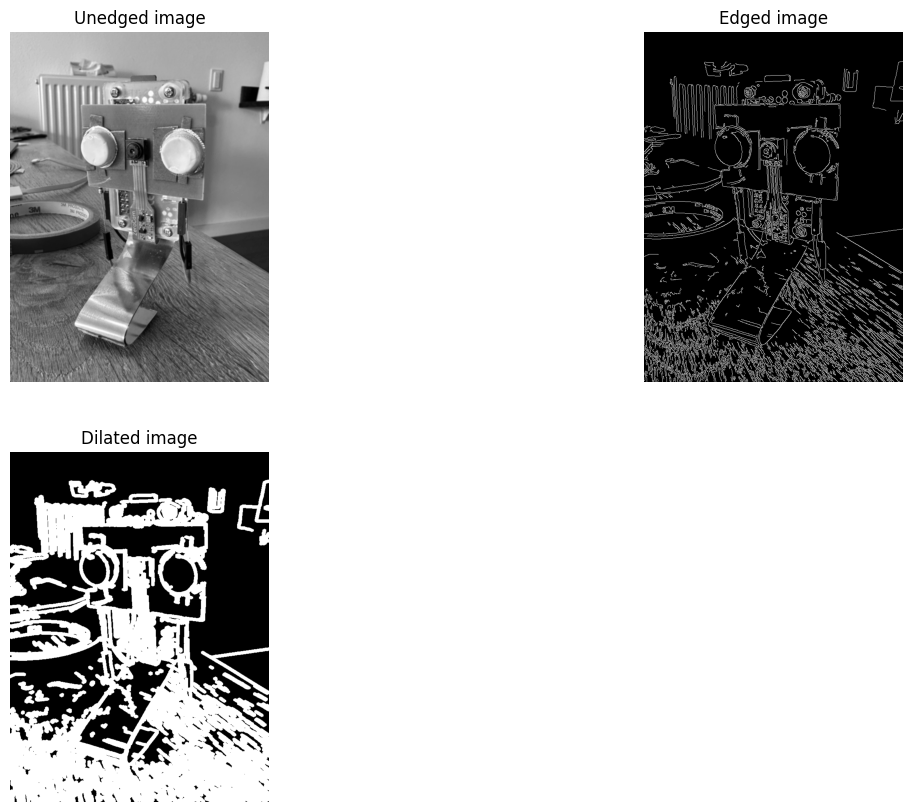

In [241]:
def get_edge_detection_thresholds(img):
    """Calculates the lower and upper thresholds for Canny edge detection"""
    sigma = 0.3
    median = np.median(img)
    lower = int(max(0, (1.0 - sigma) * median))
    upper = int(min(255, (1.0 + sigma) * median))
    return (lower, upper)

edge_find_image_height = 900
find_display_image = orig.copy()
find_display_image = cv2.cvtColor(find_display_image, cv2.COLOR_RGB2GRAY)

# Resize the image for more accurate contour detection
(h, w) = find_display_image.shape[:2]
ratio = edge_find_image_height / float(h)
dim = (int(w * ratio), edge_find_image_height)
find_display_image = cv2.resize(find_display_image, dim, interpolation=cv2.INTER_AREA)

# Apply blur and detect edges
find_display_image = cv2.GaussianBlur(find_display_image, (3, 3), 0)
(lower, upper) = get_edge_detection_thresholds(find_display_image)
print(lower, upper)
edged = cv2.Canny(find_display_image, lower, upper)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
dilated = cv2.dilate(edged, kernel, iterations=2)

fig = plt.figure(figsize=(15, 10))
fig.add_subplot(2, 2, 1)
plt.imshow(find_display_image, cmap="gray")
plt.axis("off")
plt.title("Unedged image")

fig.add_subplot(2, 2, 2)
plt.imshow(edged, cmap="gray")
plt.axis("off")
plt.title("Edged image")

fig.add_subplot(2, 2, 3)
plt.imshow(dilated, cmap="gray")
plt.axis("off")
plt.title("Dilated image")

Found 458 total contours out of which 223 are rectangular
Display contour: (array([[ 421., 1219.],
       [ 405., 1225.],
       [ 394., 1206.],
       [ 394., 1206.]], dtype=float32), (29, 17))


Text(0.5, 1.0, 'Original image')

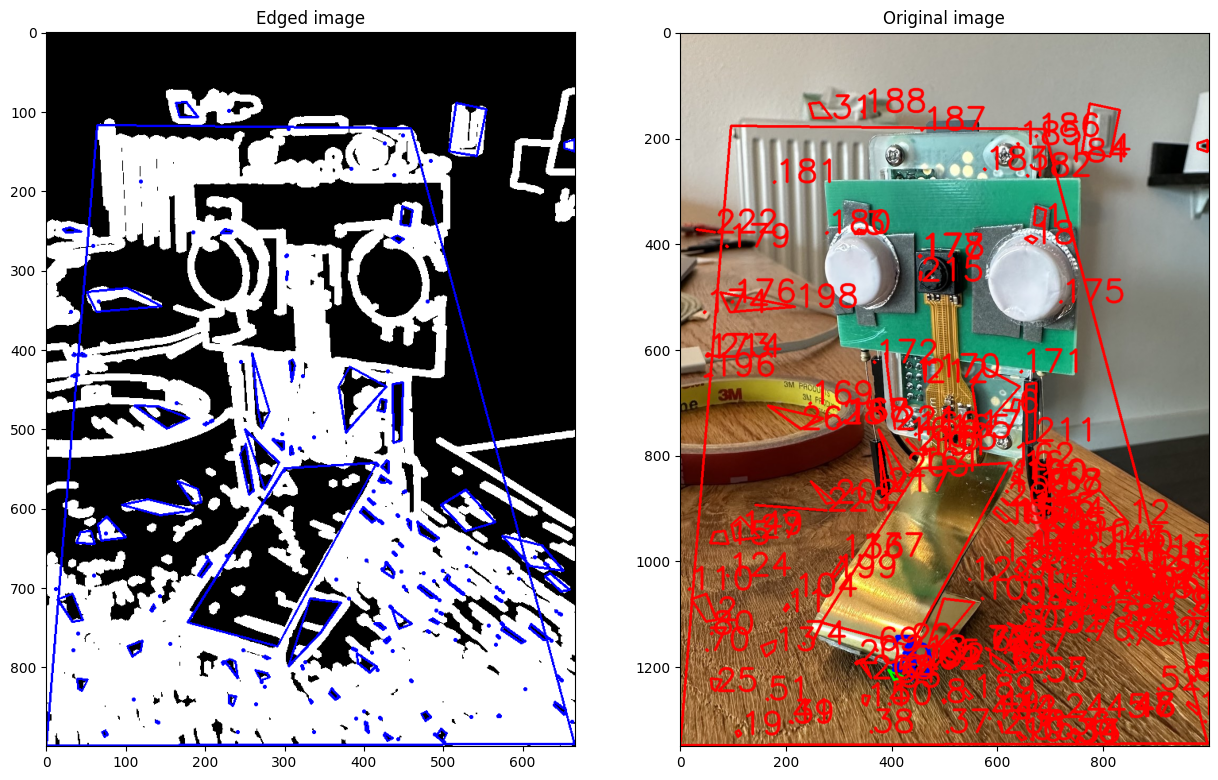

In [242]:
contours_original_image = orig.copy()
contours_detection_image = cv2.cvtColor(dilated.copy(), cv2.COLOR_GRAY2RGB)

def get_drawable_contour(contour):
    """Converts simple contour representation to one suitable for cv2.drawContours"""
    return np.int32([contour]).reshape((-1, 1, 2))

def get_rectangular_contours(contours):
    """Approximates provided contours and returns only those which have 4 vertices"""
    res = []
    for contour in contours:
        peri = cv2.arcLength(contour, closed=True)
        approx = cv2.approxPolyDP(contour, 0.04 * peri, closed=True)
        hull = cv2.convexHull(approx)
        if len(hull) == 4:
            res.append(hull)
    return res

def get_scaled_contour(contour, ratio):
    """Scales provided contour with provided ratio"""
    return np.floor_divide(contour, ratio).astype(int)

def get_euler_distance(pt1, pt2):
    """Returns distance between two points in two-dimentional space"""
    return np.sqrt(np.square(pt1[0] - pt2[0]) + np.square(pt1[1] - pt2[1]))

def curried_get_distance(pt1):
    """Returns curried version of get_euler_distance function"""
    return lambda pt2: get_euler_distance(pt1, pt2)

def get_normalized_contour_with_dimentions(contour):
    """
    Normalizes rectangular contour for vertices to have deterministic indexes
    and calculates their width and height
    """
    contour = contour.reshape(4, 2)
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int32(box)

    # Normalize vertices by aligning them to minimum area rotated bounding box vertices
    v_tl = min(contour, key=curried_get_distance(box[2]))
    v_tr = min(contour, key=curried_get_distance(box[3]))
    v_bl = min(contour, key=curried_get_distance(box[1]))
    v_br = min(contour, key=curried_get_distance(box[0]))
    new_vertices = (
        # Account for potential rectangle rotation
        [v_tl, v_tr, v_br, v_bl] if rect[2] >= 45 else [v_tr, v_br, v_bl, v_tl]
    )

    # Calculate contour dimensions
    contour = np.float32(new_vertices)
    contour_width_1 = get_euler_distance(contour[0], contour[1])
    contour_width_2 = get_euler_distance(contour[3], contour[2])
    contour_height_1 = get_euler_distance(contour[0], contour[3])
    contour_height_2 = get_euler_distance(contour[1], contour[2])
    contour_width_candidate = int(max(contour_width_1, contour_width_2))
    contour_height_candidate = int(max(contour_height_1, contour_height_2))
    contour_width = max(contour_width_candidate, contour_height_candidate)
    contour_height = min(contour_width_candidate, contour_height_candidate)

    return (contour, (contour_width, contour_height))

contours, _ = cv2.findContours(dilated, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

rectangular_contours = get_rectangular_contours(contours)
scaled_normalized_contours = [
    get_normalized_contour_with_dimentions(get_scaled_contour(c, ratio))
    for c in rectangular_contours
]
print(f"Found {len(contours)} total contours out of which {len(rectangular_contours)} are rectangular")

# Assume that display contour is the rectangular contour which
# aspect ratio is the closest to 1.72
sorted_contours = sorted(
    scaled_normalized_contours,
    # Handle edge cases to prevent division by zero with sufficiently
    # large number to go to the end of the list
    key=lambda nc: abs(1.72 - nc[1][0] / nc[1][1]) if nc[1][1] else 100,
)
display_contour = next(iter(sorted_contours), None)
print(f"Display contour: {display_contour}")

cv2.drawContours(contours_detection_image, rectangular_contours, -1, (0, 0, 255), 2)
cv2.drawContours(contours_original_image, [get_drawable_contour(c[0]) for c in sorted_contours], -1, (255, 0, 0), 3)
cv2.drawContours(contours_original_image, [get_drawable_contour(display_contour[0])], -1, (0, 255, 0), 3)

# Draw display contour vertex indices
for i in range(len(display_contour[0])):
    cv2.putText(
        contours_original_image,
        str(i),
        np.int32(display_contour[0][i]),
        cv2.FONT_HERSHEY_SIMPLEX,
        3,
        (0, 0, 255),
        5,
        cv2.LINE_AA
    )

# Draw sorted contours' indices
for i in range(len(sorted_contours)):
    cv2.putText(
        contours_original_image,
        str(i),
        np.int32(sorted_contours[i][0][0]),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 0, 0),
        4,
        cv2.LINE_AA
    )

fig = plt.figure(figsize=(15, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(contours_detection_image, cmap="gray")
plt.title("Edged image")

fig.add_subplot(1, 2, 2)
plt.imshow(contours_original_image, cmap="gray")
plt.title("Original image")

W x H = 29 x 17: [[ 421. 1219.]
 [ 405. 1225.]
 [ 394. 1206.]
 [ 394. 1206.]]


Text(0.5, 1.0, 'Cropped and warped LCD')

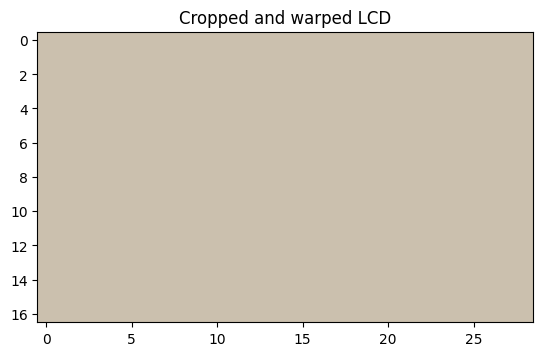

In [243]:
(display_width, display_height) = display_contour[1]
display_dst_pts = np.float32([[display_width, display_height], [0, display_height], [0, 0], [display_width, 0]])

# Extract LCD image and perform perspective transformation
transform_matrix = cv2.getPerspectiveTransform(display_contour[0], display_dst_pts)
warp = cv2.warpPerspective(orig, transform_matrix, (display_width, display_height), flags=cv2.INTER_LINEAR)

print(f"W x H = {display_width} x {display_height}: {display_contour[0]}")
plt.imshow(warp)
plt.title("Cropped and warped LCD")

In [244]:
def smooth_image(img):
    """Smoothes the image"""
    _, th1 = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)
    _, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (3, 3), 0)
    _, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

def remove_noise_and_smooth(img):
    """Prepares image for OCR"""
    # Apply dilation and erosion to remove some noise
    kernel = np.ones((3, 3), np.uint8)
    filtered = cv2.adaptiveThreshold(
        img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 61, 8
    )
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = smooth_image(img)
    or_image = cv2.bitwise_or(img, closing)
    return or_image

def get_binarized_readings_roi(display_img, display_width, display_height):
    """Returns cropped binarized image of readings suitable for OCR"""
    # Prepare image for OCR with tesseract
    ocr_image = display_img.copy()
    ocr_image = cv2.cvtColor(ocr_image, cv2.COLOR_BGR2GRAY)
    ocr_image = remove_noise_and_smooth(ocr_image)

    # Knowing the location of the readings within the LCD ROI we can extract the readings ROI
    readings_left_edge = int(display_width * 0.144)
    readings_right_edge = int(display_width * 0.965)
    readings_top_edge = int(display_height * 0.367)
    readings_bottom_edge = int(display_height * 0.650)
    readings_roi = ocr_image[
        readings_top_edge:readings_bottom_edge, readings_left_edge:readings_right_edge
    ]

    # Pad image with white border to improve OCR accuracy
    readings_roi = cv2.copyMakeBorder(
        readings_roi, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=(255, 255, 255)
    )

    return readings_roi

def recognize(roi):
    """Performs OCR and returns recognized meter readings"""
    tesseract_config = (
        "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789 "
        + "--tessdata-dir ./app/reader/ssd"
    )
    text = pytesseract.image_to_string(roi, lang="ssd", config=tesseract_config)
    return text

# Perform OCR
readings_roi = get_binarized_readings_roi(warp, display_width, display_height)
readings = recognize(readings_roi).strip()
readings_float = float(readings) / 1000

if readings_float < 0.1:
    raise ReaderError(
        f"Incorrect readings: {readings_float}, " + \
        "most likely display contour was not properly identified"
    )

plt.imshow(readings_roi, cmap="gray")
plt.title(f"Meter readings: {readings}")

ReaderError: Incorrect readings: 0.004,             most likely display contour was not properly identified